# Inn the Neighborhood - Rental Price Prediction

## Project Brief

Inn the Neighborhood is an online platform that allows people to rent out their properties for short stays. Currently, the webpage for renters has a conversion rate of 2%. This means that most people leave the platform without signing up. 

The product manager would like to increase this conversion rate. They are interested in developing an application to help people estimate the money they could earn renting out their living space. They hope that this would make people more likely to sign up.

The company has a dataset that includes details about each property rented, as well as the price charged per night. They want to avoid estimating prices that are more than 25 dollars off of the actual price, as this may discourage people.

OBjective is to present your findings in two formats:
- Submit a written report summarising your analysis to your manager. As a data science manager, your manager has a strong technical background and wants to understand what you have done and why. 
- Share  findings with the product manager in a 10 minute presentation. The product manager has no data science background but is familiar with basic data related terminology. 

The data for this analysis can be accessed here: `"data/rentals.csv"`

## The Data
- `id`: Numeric, the unique identification number of the property
- `latitude`: Numeric, the latitude of the property
- `longitude`: Numeric, the longitude of the property
- `property_type`: Character, the type of property (e.g., apartment, house, etc)
- `room_type`: Character, the type of room (e.g., private room, entire home, etc)
- `bathrooms`: Numeric, the number of bathrooms
- `bedrooms`: Numeric, the number of bedrooms
- `minimum_nights`: Numeric, the minimum number of nights someone can book
- `price`: Character, the dollars per night charged

## Import Libraries

In [1]:
# Installations
#!pip install geopy lightgbm xgboost verstack --upgrade

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from verstack import LGBMTuner
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

2022-05-06 13:52:10.244571: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-06 13:52:10.244605: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load the data

In [4]:
rentals_csv = pd.read_csv('data/rentals.csv')
df = rentals_csv.copy()
df.head()

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
0,958,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,$170.00
1,3850,37.75402,-122.45805,House,Private room,1.0,1.0,1,$99.00
2,5858,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,$235.00
3,7918,37.76669,-122.45250,Apartment,Private room,4.0,1.0,32,$65.00
4,8142,37.76487,-122.45183,Apartment,Private room,4.0,1.0,32,$65.00


## Data Size and Structure
- Dataset comprises of 8111 observations and 7 characteristics.
- `id` can be treated as the index
- 7 independent variables: `latitude`, `longitude`, `property_type`, `room_type`, `bathrooms`, `bedrooms`, `minimum_nights`
    * 5 numerical features, 2 categorical features
- 1 dependent variable: `price`
- `price` is treated as `object` type because of the non-numeric characters in cell, e.g."$", ",". 
- 2 variable columns has null/missing values.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8111 entries, 0 to 8110
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              8111 non-null   int64  
 1   latitude        8111 non-null   float64
 2   longitude       8111 non-null   float64
 3   property_type   8111 non-null   object 
 4   room_type       8111 non-null   object 
 5   bathrooms       8099 non-null   float64
 6   bedrooms        8107 non-null   float64
 7   minimum_nights  8111 non-null   int64  
 8   price           8111 non-null   object 
dtypes: float64(4), int64(2), object(3)
memory usage: 570.4+ KB


In [6]:
# Set id as index
df.set_index('id', inplace=True)

In [7]:
 def remove_nonnumeric(string):
    """Remove non-numeric characters from string using regex.
    
    INPUTS:
    string - str
    
    OUTPUT
    output - str
    """
    output = re.sub("[^0-9]", "", string)
    return output

# Remove non-numeric characters
df.price = df.price.apply(lambda x: remove_nonnumeric(x))

# Change dtype of price from str to float64 
df.price = df.price.astype('float64') / 100

### Summary Statistics
- Features have different scales and units.
- There is a narrow distribution of latitude and longitude values, which suggest the dataset contains properties in the same region.
- There are extreme outliers in `minimum_nights`, with a max value of `100000000` nights, which would be over 273972 years.

In [8]:
df.describe()

,latitude,longitude,bathrooms,bedrooms,minimum_nights,price
count,8111.000000,8111.000000,8099.000000,8107.000000,8.111000e+03,8111.000000
mean,37.766054,-122.430107,1.395975,1.345874,1.234526e+04,225.407101
std,0.022937,0.026967,0.923213,0.925298,1.110357e+06,412.253039
min,37.704630,-122.513060,0.000000,0.000000,1.000000e+00,0.000000
25%,37.751450,-122.442830,1.000000,1.000000,2.000000e+00,100.000000
50%,37.769150,-122.424650,1.000000,1.000000,4.000000e+00,150.000000
75%,37.785670,-122.410615,1.500000,2.000000,3.000000e+01,240.000000
max,37.828790,-122.368570,14.000000,14.000000,1.000000e+08,10000.000000


In [9]:
# Remove outliers in columns minimum_nights and price using IQR
quant_cols = ["minimum_nights", "price"]

for col_name in quant_cols:
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr

    df = df[df[col_name] < high]
    df = df[df[col_name] > low]
df.describe()

,latitude,longitude,bathrooms,bedrooms,minimum_nights,price
count,7389.000000,7389.000000,7377.000000,7386.000000,7389.000000,7389.000000
mean,37.765445,-122.430049,1.339637,1.225968,15.288131,162.706320
std,0.023001,0.027253,0.906060,0.792813,14.291618,87.043561
min,37.704630,-122.513060,0.000000,0.000000,1.000000,0.000000
25%,37.750730,-122.442950,1.000000,1.000000,2.000000,98.000000
50%,37.768500,-122.424370,1.000000,1.000000,5.000000,148.000000
75%,37.785220,-122.410380,1.500000,2.000000,30.000000,208.000000
max,37.828790,-122.368570,14.000000,14.000000,70.000000,449.000000


### Completeness of Data
- Less than 0.2% of missing values present in columns bathroom and bedrooms
- Since, the missing observations only account for a small amount of the dataset, we can drop these observations.

In [10]:
# Percentage of dataset is null
df.isnull().sum() / len(df) * 100

latitude          0.000000
longitude         0.000000
property_type     0.000000
room_type         0.000000
bathrooms         0.162404
bedrooms          0.040601
minimum_nights    0.000000
price             0.000000
dtype: float64

In [11]:
# Drop null values
df = df.dropna()

## Data Cleaning Summary
- Set `id` as index.
- Removed non-numeric characters from `price`.
- Dropped extreme outliers in `minimum_nights` and `price`.
- Drop rows with null values.

## Exploratory Data Analysis

### Correlation
- There is a positive correlation between number of bathrooms and bedrooms.
- Price has the highest positive correlation with the number of bedrooms.
- Price has a negative correlation with the number of bathrooms and minimum nights.
- There is no strong correlation between variables. 

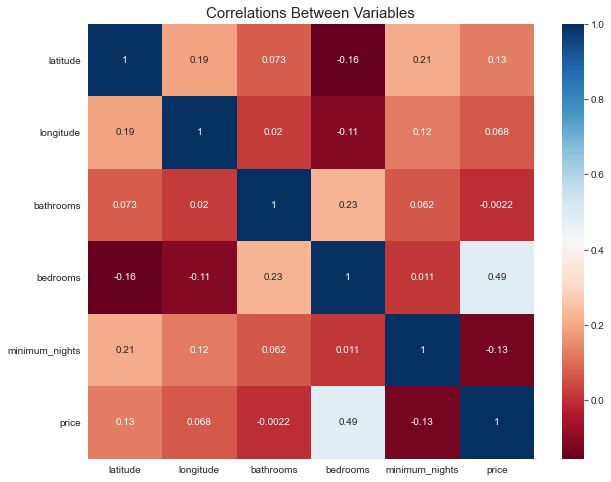

In [12]:
# Visualizing the correlations between numerical variables
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap="RdBu", annot=True)
plt.title("Correlations Between Variables", size=15)
plt.show()

### Price
Our target variable `price` is a continuous numerical variable. <br>
The distribution is right skewed, with most properties costing around $100.00 per night. <br>
Recall that outliers have already been removed from `price`.

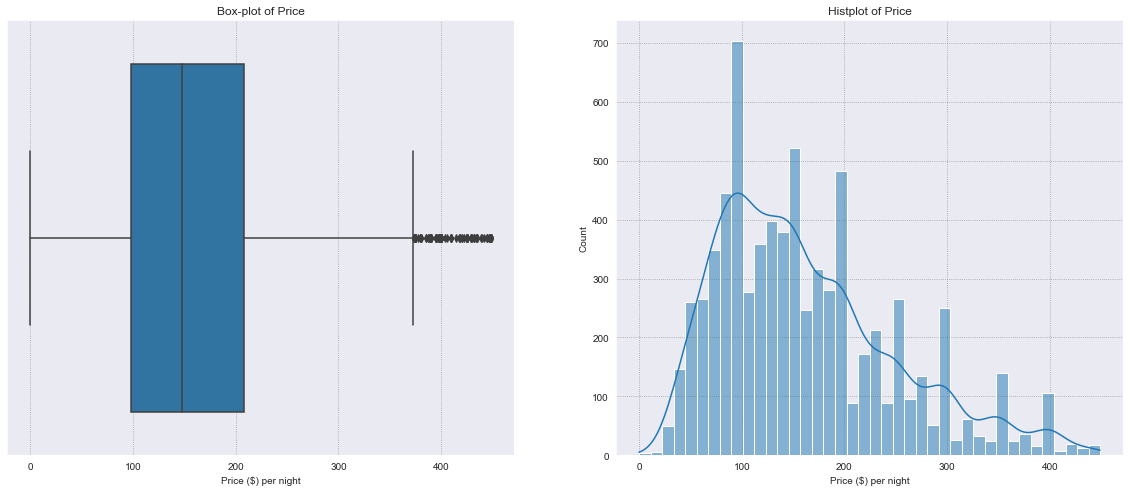

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.boxplot(x='price', data=df, ax=ax1)
sns.histplot(x='price', data=df, ax=ax2, kde=True)
ax1.set_title('Box-plot of Price')
ax2.set_title('Histplot of Price')
ax1.set_xlabel('Price ($) per night')
ax2.set_xlabel('Price ($) per night')
plt.show()

### Bedrooms
`bedrooms` is a discrete numerical variable. It has the highest positive correlation with `price`. <br>
The distribution is right skewed, with most properties having 1 bathroom.
Different variability of the price is present for each number of bedrooms.

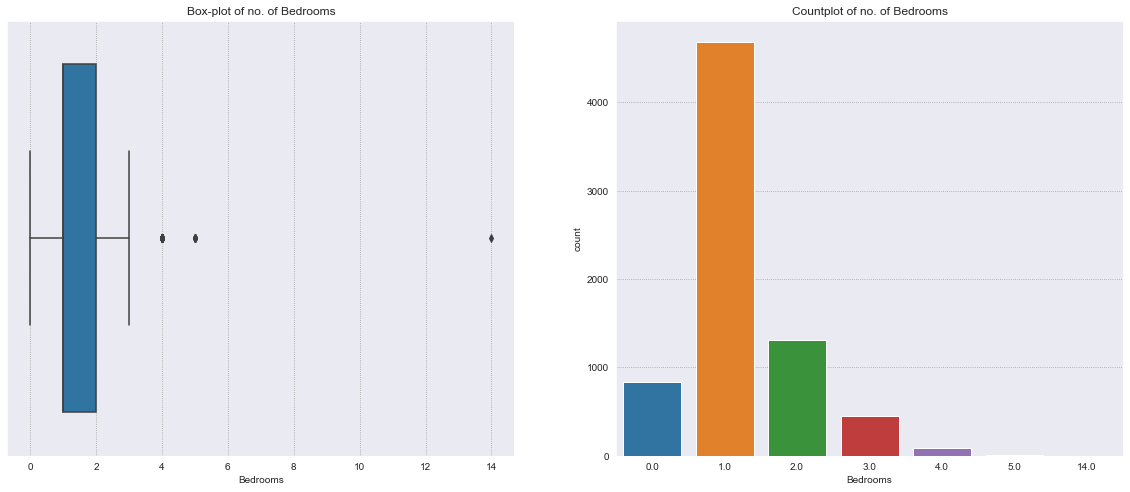

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.boxplot(x='bedrooms', data=df, ax=ax1)
sns.countplot(x='bedrooms', data=df, ax=ax2)
ax1.set_title('Box-plot of no. of Bedrooms')
ax2.set_title('Countplot of no. of Bedrooms')
ax1.set_xlabel('Bedrooms')
ax2.set_xlabel('Bedrooms')
plt.show()

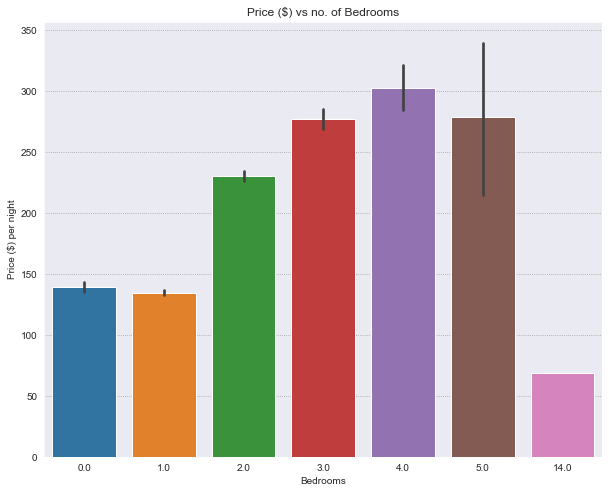

In [15]:
# Price corresponding to no. of Bedrooms
plt.figure(figsize=(10,8))
ax = sns.barplot(y='price', x='bedrooms', data=df)
ax.set_title('Price ($) vs no. of Bedrooms')
ax.set_xlabel('Bedrooms')
ax.set_ylabel('Price ($) per night')
plt.show()

### Bathrooms
`bathrooms` is a discrete numerical variable. It has a weak positive correlation with bedrooms.<br>
**Contextual information:** A full bathroom has a sink, toilet, and either a tub/shower combo or separate tub and shower. Whereas, a half-bath has a sink and a toilet - no tub or shower.<br>
The distribution is right skewed, with most properties having 1 bathroom. Different variability of the price is present for each number of bathrooms.

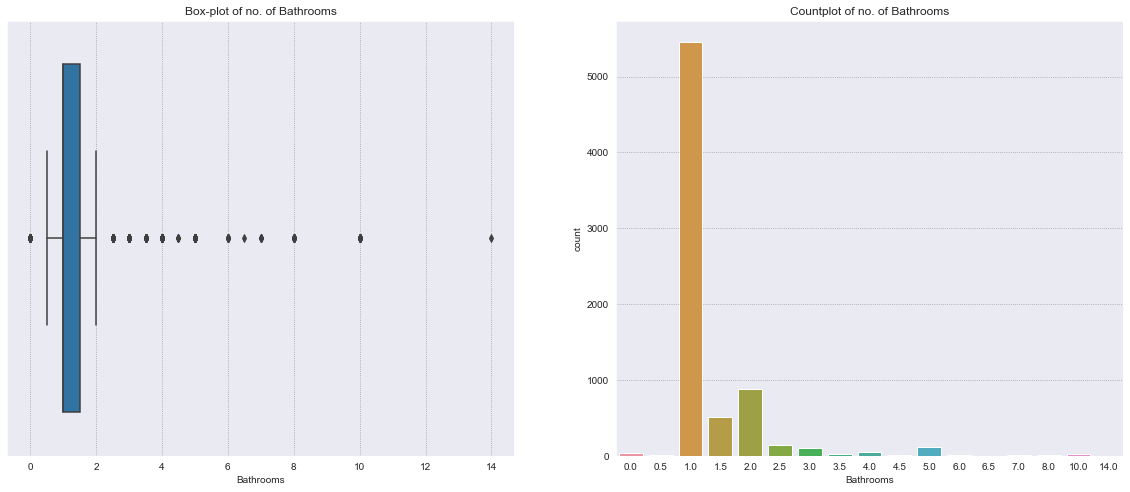

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.boxplot(x='bathrooms', data=df, ax=ax1)
sns.countplot(x='bathrooms', data=df, ax=ax2)
ax1.set_title('Box-plot of no. of Bathrooms')
ax2.set_title('Countplot of no. of Bathrooms')
ax1.set_xlabel('Bathrooms')
ax2.set_xlabel('Bathrooms')
plt.show()

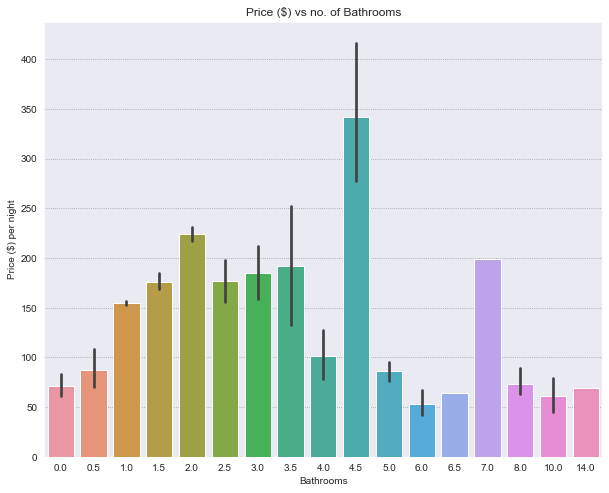

In [17]:
# Price corresponding to no. of Bathrooms
plt.figure(figsize=(10,8))
ax = sns.barplot(y='price', x='bathrooms', data=df)
ax.set_title('Price ($) vs no. of Bathrooms')
ax.set_xlabel('Bathrooms')
ax.set_ylabel('Price ($) per night')
plt.show()

### Minimum Nights
`minimum_nights` is a discrete numerical variable. <br>
The distribution is right skewed and bimodal, with most properties requiring a minimum of 30 or 1-3 nights of stay. <br>
Recall that outliers have already been removed from `Minimum Nights`.

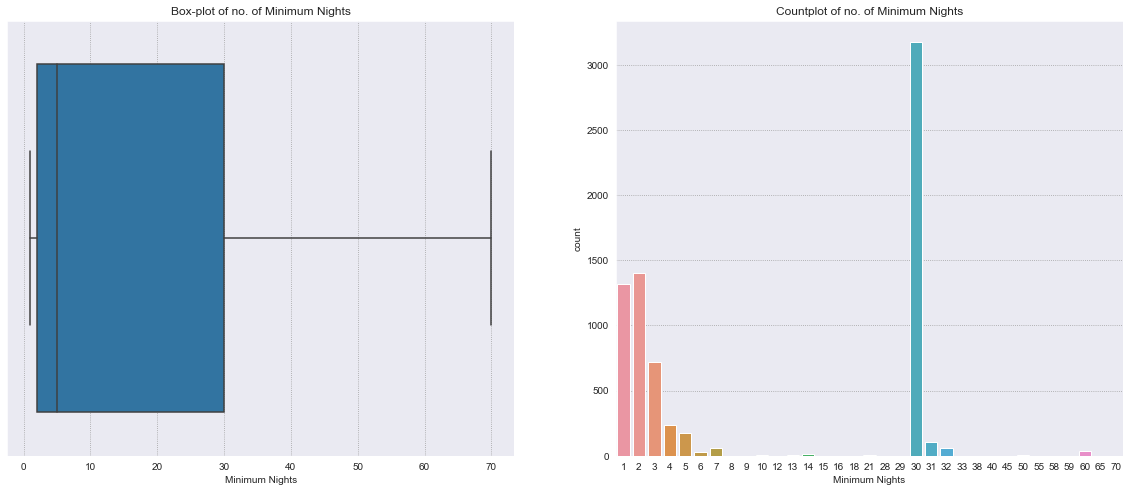

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.boxplot(x='minimum_nights', data=df, ax=ax1)
sns.countplot(x='minimum_nights', data=df, ax=ax2)
ax1.set_title('Box-plot of no. of Minimum Nights')
ax2.set_title('Countplot of no. of Minimum Nights')
ax1.set_xlabel('Minimum Nights')
ax2.set_xlabel('Minimum Nights')
plt.show()

### Property Type
`property_type` is a categorical variable. There are 26 property types.<br>
Most properties are Apartments. The most expensive type being resorts, and the cheapest being Camper/RV. <br>
Different variability of the price is present for each property type. For example, cottages has a wide range of prices, whereas apartments have a narrow range.

No. of property types: 26


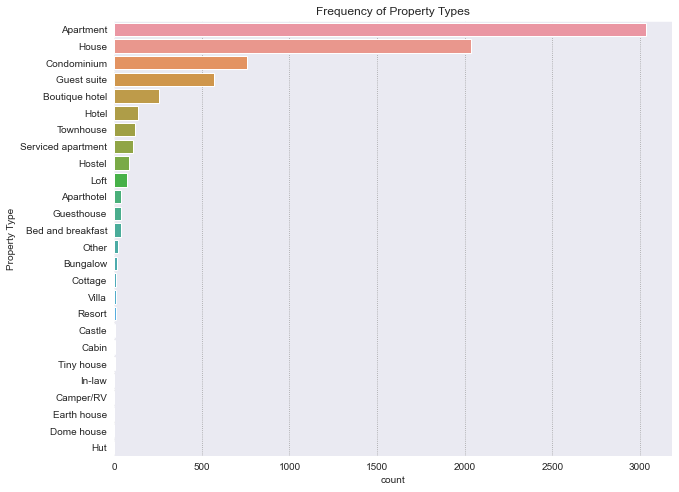

In [19]:
print(f"No. of property types: {len(df['property_type'].unique())}")

# Frequency of each property type
plt.figure(figsize=(10,8))
ax = sns.countplot(y='property_type', data=df, order = df['property_type'].value_counts().index)
ax.set_title('Frequency of Property Types')
ax.set_ylabel('Property Type')
plt.show()

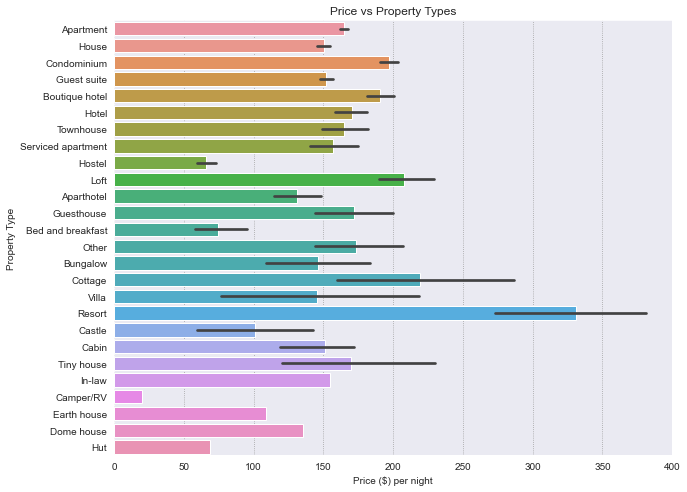

In [20]:
# Price of each property type
plt.figure(figsize=(10,8))
ax = sns.barplot(x='price', y='property_type', data=df, order = df['property_type'].value_counts().index)
ax.set_title('Price vs Property Types')
ax.set_ylabel('Property Type')
ax.set_xlabel('Price ($) per night')
plt.show()

### Room Type
`room_type` is a categorical variable. There are 4 room types. <br>
Most rooms are Entire home/apt. The most expensive type being Entire home/apt, and the cheapest being Shared Room.

No. of room types: 4


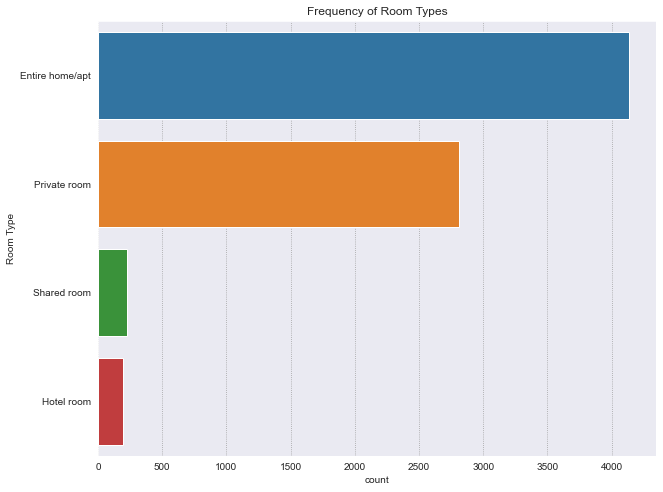

In [21]:
print(f"No. of room types: {len(df['room_type'].unique())}")

# Frequency of each room type
plt.figure(figsize=(10,8))
ax = sns.countplot(y='room_type', data=df, order = df['room_type'].value_counts().index)
ax.set_title('Frequency of Room Types')
ax.set_ylabel('Room Type')
plt.show()

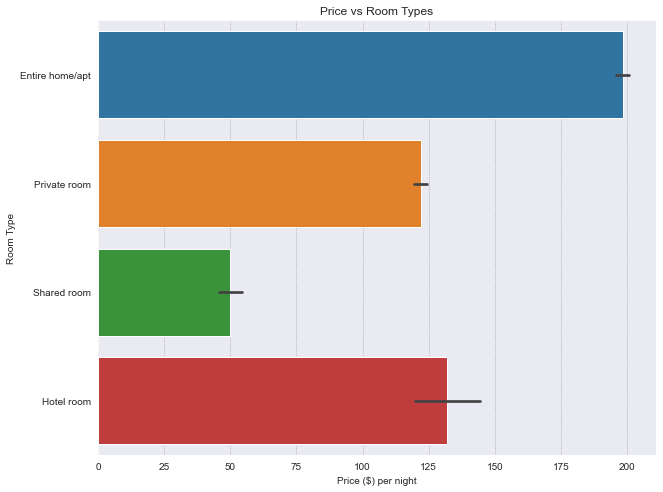

In [22]:
# Price of each room type
plt.figure(figsize=(10,8))
ax = sns.barplot(x='price', y='room_type', data=df, order = df['room_type'].value_counts().index)
ax.set_title('Price vs Room Types')
ax.set_ylabel('Room Type')
ax.set_xlabel('Price ($) per night')
plt.show()

### Latitude and Longitude
Properties are located near San Francisco. <br>
Scatterplot does not show distinct price clusters based on latitude and longitude.

1449, Baker Street, Western Addition, San Francisco, California, 94115, United States


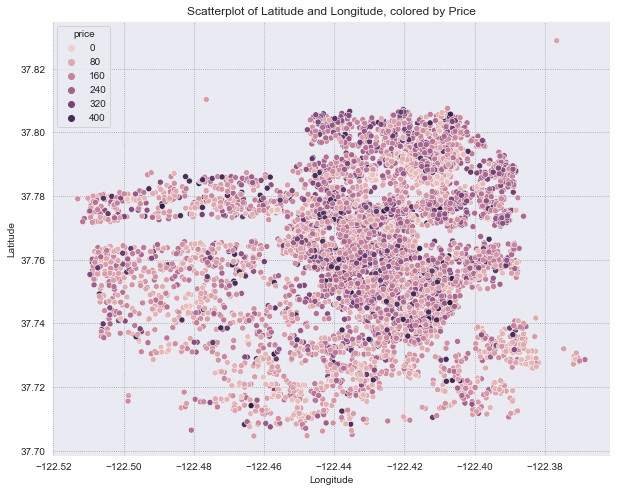

In [23]:
# Get address from Latitude and Longitude
geolocator = Nominatim(user_agent="geoapi")
sample_df = df.sample(1)
Latitude, Longitude = sample_df['latitude'].astype(str), sample_df['longitude'].astype(str)
location = geolocator.reverse(Latitude + "," + Longitude)
print(location)

# Visualization of latitude and longitude
plt.figure(figsize=(10,8))
sns.scatterplot(data=df, x='longitude', y='latitude', hue='price')
plt.title('Scatterplot of Latitude and Longitude, colored by Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Train Test Split
Split the data to train (80%) and test (20%) to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.

In [24]:
X = df.iloc[:, :-1] # Features
y = df['price'] # Target

In [25]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

print('X train data {}'.format(X_train.shape))
print('y train data {}'.format(y_train.shape))
print('X test data  {}'.format(X_test.shape))
print('y test data  {}'.format(y_test.shape))

X train data (5899, 7)
y train data (5899,)
X test data  (1475, 7)
y test data  (1475,)


## Feature Engineering
Performed after Train Test split to prevent information leakage from the test set.
- Convert categorical variables into a format that can be readily used by machine learning algorithms using One-Hot-Encoding.
- Cartesian coordinates into polar coordinates
- Scale input variables to improve the convergence of algorithms that do not possess the property of scale invariance.

### One-Hot-Encoding

In [26]:
# Categorical Features
cat_cols = ['property_type', 'room_type']

# Transformer Object
ohe = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), 
     cat_cols))

def encode(transformer, df):
    """ Apply transformer columns of a pandas DataFrame
    
    INPUTS:
    transformer: transformer object
    df: pandas DataFrame
    
    OUTPUT:
    transformed_df: transformed pandas DataFrame
    
    """
    transformed = transformer.fit_transform(df[cat_cols]).toarray()
    transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names())
    return transformed_df

# Apply transformation on both Train and Test set
encoded_train = encode(ohe, X_train)
encoded_train.index = X_train.index
encoded_test = encode(ohe, X_test)
encoded_test.index = X_test.index

print(f"encoded_train shape: {encoded_train.shape}")
print(f"encoded_test shape: {encoded_test.shape}")

# Join encoded cols to Train and Test set, drop original column
X_train = X_train.join(encoded_train)
X_train.drop(cat_cols, axis=1, inplace=True)
X_test = X_test.join(encoded_test)
X_test.drop(cat_cols, axis=1, inplace=True)

# Ensure Train and Test have the same no. of columns
train_cols = list(X_train.columns)
test_cols = list(X_test.columns)
cols_not_in_test = {c:0 for c in train_cols if c not in test_cols}
X_test = X_test.assign(**cols_not_in_test)
cols_not_in_train = {c:0 for c in test_cols if c not in train_cols}
X_train = X_train.assign(**cols_not_in_train)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

encoded_train shape: (5899, 30)
encoded_test shape: (1475, 23)
X_train shape: (5899, 35)
X_test shape: (1475, 35)


### Geospaital Features
Transform Cartesian coordinates into polar coordinates.

In [27]:
# Geospatial Features
geo_cols = ['latitude', 'longitude']

def cart2pol(x, y):
    """ Convert cartesian coordinates into polar coordinates
    
    INPUT
    x, y: Cartesian coorindates
    
    OUTPUT
    rho, phi: Polar coordinates
    """
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return rho, phi

rho, phi = cart2pol(X_train['longitude'], X_train['latitude'])
X_train['rho'] = rho
X_train['phi'] = phi
rho, phi = cart2pol(X_test['longitude'], X_test['latitude'])
X_test['rho'] = rho
X_test['phi'] = phi

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (5899, 37)
X_test shape: (1475, 37)


## Variable Importance with Random Forest
Using a simple random forest with 100 trees to get a quick overview of the top 5 relative permutation importance for each variable. <br>
According to the random forest, `bedrooms` is the most important feature. This is expected because it has the highest correlation to the `price`.

In [28]:
rf = RandomForestRegressor(n_estimators=100, random_state=2022)
rf.fit(X_train, y_train)
perm_importance = permutation_importance(rf, X_test, y_test)

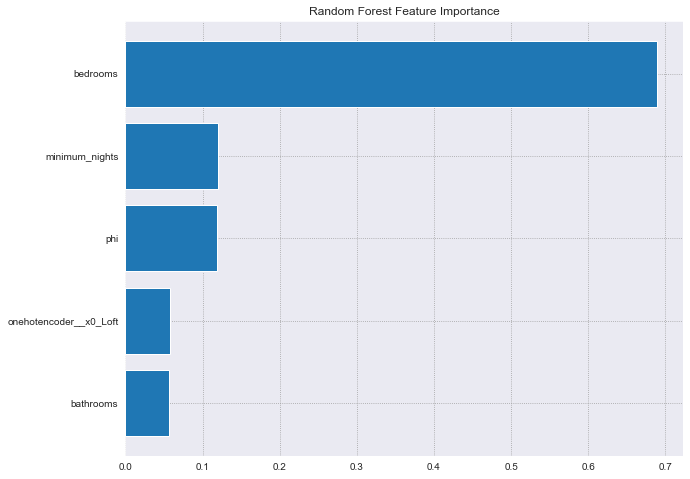

In [29]:
plt.figure(figsize=(10,8))
sorted_idx = perm_importance.importances_mean.argsort()[-5:]
plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title("Random Forest Feature Importance")
plt.show()

## Feature Selection
Recognize that many new features were generated during feature engineering. <br>
Using Lasso Regularization to identify and select a subset of input variables that are most relevant to the target variable. <br>
Non-important features are removed.

In [30]:
# Lasso Regularization
sel_lasso = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear', random_state=2022))
sel_lasso.fit(X_train, y_train)
sel_lasso.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False,  True, False, False, False,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True])

In [31]:
# make a list with the selected features and print the outputs
selected_feat = X_train.columns[(sel_lasso.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(np.sum(sel_lasso.estimator_.coef_ == 0)))

total features: 37
selected features: 27
features with coefficients shrank to zero: 10531


In [32]:
X_train = X_train[selected_feat]
X_test = X_test[selected_feat]
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (5899, 27)
X_test shape: (1475, 27)


## Model Selection
Explore different supervised regression models since the target variable is labeled and continuous. <br>
Using k-folds cross validation to estimate and compare the performance of models on out-of-sample data. Identify, which model is worth improving upon. <br>
LGBMRegressor - (Microsoft’s implementation of gradient boosted machines) - gives the best results out of models.

In [33]:
def neural_network():
    # No. of neuron based on the number of available features
    model = Sequential()
    model.add(Dense(26,activation='relu'))
    model.add(Dense(26,activation='relu'))
    model.add(Dense(26,activation='relu'))
    model.add(Dense(26,activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='Adam',loss='mse')
    return model

In [34]:
# Pipelines for Machine Learning models
pipelines = []
pipelines.append(('Linear Regression', Pipeline([('scaler', MinMaxScaler()), ('LR', LinearRegression())])))
pipelines.append(('KNN Regressor', Pipeline([('scaler', MinMaxScaler()), ('KNNR', KNeighborsRegressor())])))
pipelines.append(('SupportVectorRegressor', Pipeline([('scaler', MinMaxScaler()), ('SVR', SVR())])))
pipelines.append(('DecisionTreeRegressor', Pipeline([('scaler', MinMaxScaler()), ('DTR', DecisionTreeRegressor())])))
pipelines.append(('AdaboostRegressor', Pipeline([('scaler', MinMaxScaler()), ('ABR', AdaBoostRegressor())])))
pipelines.append(('RandomForestRegressor', Pipeline([('scaler', MinMaxScaler()), ('RBR', RandomForestRegressor())])))
pipelines.append(('BaggingRegressor', Pipeline([('scaler', MinMaxScaler()), ('BGR', BaggingRegressor())])))
pipelines.append(('GradientBoostRegressor', Pipeline([('scaler', MinMaxScaler()), ('GBR', GradientBoostingRegressor())])))
pipelines.append(('LGBMRegressor', Pipeline([('scaler', MinMaxScaler()), ('lightGBM', LGBMRegressor())])))
pipelines.append(('XGBRegressor', Pipeline([('scaler', MinMaxScaler()), ('XGB', XGBRegressor())])))
pipelines.append(('Neural Network', Pipeline([('scaler', MinMaxScaler()), ('NN', neural_network())])))

2022-05-06 13:55:35.288773: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-06 13:55:35.288805: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-06 13:55:35.288828: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (77be27d7-7f52-4c8e-b468-d0a291019f80): /proc/driver/nvidia/version does not exist
2022-05-06 13:55:35.289038: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
# Create empty dataframe to store the results
cv_scores = pd.DataFrame({'Regressor':[], 'RMSE':[], 'Std':[]})

# Cross-validation score for each pipeline for training data
for ind, val in enumerate(pipelines):
    name, pipeline = val
    kfold = KFold(n_splits=10) 
    rmse = np.sqrt(-cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring="neg_mean_squared_error"))
    cv_scores.loc[ind] = [name, rmse.mean(), rmse.std()]
cv_scores

166/166 [==============================] - 1s 1ms/step - loss: 21561.3203


,Regressor,RMSE,Std
0,Linear Regression,61.030364,4.655586
1,KNN Regressor,59.964974,2.316660
2,SupportVectorRegressor,71.270238,2.734177
3,DecisionTreeRegressor,74.548034,4.277726
4,AdaboostRegressor,68.978145,2.365603
5,RandomForestRegressor,55.863697,2.589026
6,BaggingRegressor,57.978998,2.580112
7,GradientBoostRegressor,56.140068,3.002398
8,LGBMRegressor,54.644028,2.939779
9,XGBRegressor,55.920699,3.306022


## Model Tuning
Using LGBMTuner from verstack - automated lightgbm models tuner with optuna (automated hyperparameter optimization framework). <br>
Using Root Mean Squared Error as the metric for 500 trials.

According to the tuned model:
- The most important hyperparameter is `num_leaves`: max number of leaves in one tree.
- The features with the most impact to the model are the geographic features `phi`, `latitude`, `rho`, `longitude`. Suggesting the location is a major factor in dictating price per night.


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 500 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 55.67789244564906
 ...........................................................................
     . Trial number: 20 finished
     .. Optimization score (lower-better): rmse: 54.29340571492496
 ...........................................................................
     . Trial number: 55 finished
     .. Optimization score (lower-better): rmse: 54.05121505929641
 ...........................................................................
     . Trial number: 95 finished
     .. Optimization score (lower-better): rmse: 52.856645986642825
 ...........................................................................
     . Trial number: 175 finished
     .. Optimization score (lower-better): rmse: 53.08965433288682
 .............................................

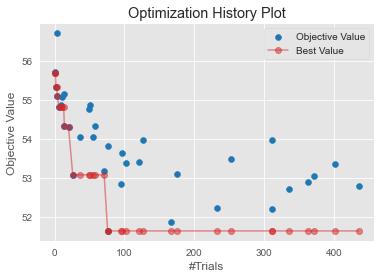

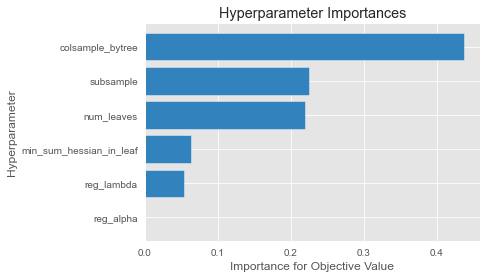

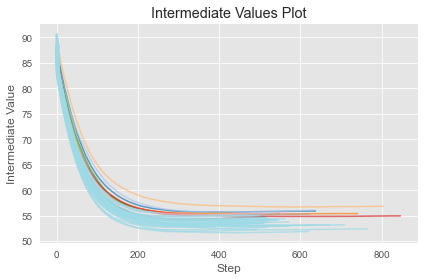

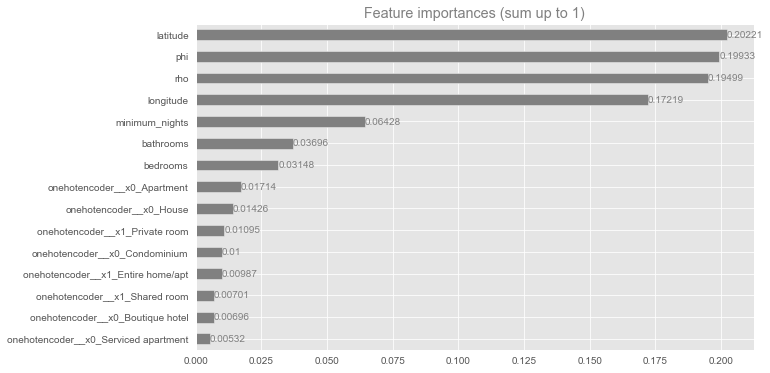


     . Optuna hyperparameters optimization finished
     .. Best trial number:76    |     rmse:            51.64429482194801
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  344   |     rmse:             55.5445339314529

Time elapsed for fit execution: 20 min 4.296 sec


In [36]:
tuner = LGBMTuner(metric = 'rmse', trials = 500)
tuner.fit(X_train, y_train)

In [37]:
# Best Performing Model
LGBMRegressor(**tuner.best_params)

LGBMRegressor(colsample_bytree=0.705868674243541, learning_rate=0.01,
              metric='rmse', min_sum_hessian_in_leaf=0.0017813151887621482,
              n_estimators=344, num_leaves=111, num_threads=14,
              objective='regression', random_state=42,
              reg_alpha=1.830273189019251e-08, reg_lambda=0.0723651402085118,
              subsample=0.6737648484996459, verbosity=-1)

In [38]:
y_pred = tuner.predict(X_test)
y_pred

array([149.52588627, 192.46170071, 239.86680096, ..., 225.76162168,
        96.80989254, 150.26631376])

## Model Evaluation
Measure model performance using Mean Squared Error, Mean Absolute Error, Root Mean Squared Error, and r2 Score.

$$ MSE(y, \hat{y}) = \frac{1}{N_{samples}} \sum_{i=0}^{n_{samples} - 1} (y_i - \hat{y_i})^2 $$
$$ MAE(y, \hat{y}) = \frac{1}{N_{samples}} \sum_{i=0}^{n_{samples} - 1} | y_i - \hat{y_i} | $$
$$ R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y_i})^2}{\sum_{i=1}^{n} (y_i - \bar{y_i})^2} $$

Hyperparameter tuning improved the model's RMSE from the base model. <br>
Nevertheless, the RMSE scores is greater than 25 indicating that the model fails to predict price within 25 dollars off of the actual price.

In [39]:
performance_dict = {'MSE': mean_squared_error(y_test, y_pred), 
                    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
                    'MAE': mean_absolute_error(y_test, y_pred), 
                    'R2 Score': r2_score(y_test, y_pred)
                   }

performance_df = pd.DataFrame(performance_dict.items(), columns=['Metric', 'Score'])
performance_df

,Metric,Score
0,MSE,2899.750785
1,RMSE,53.849334
2,MAE,39.367336
3,R2 Score,0.612258


## Outcome Summary
Aimed to predict price, allowing renters to estimate how much they could earn renting out their living space. <br>
Adopted Supervised Machine Learning approach to predict labeled continuous target variable `price` using details about each property rented, as well as the price charged per night. <br>
After model selection and tuning, the best model: 
```
LGBMRegressor(colsample_bytree=0.6965557560964968, learning_rate=0.01,
              metric='rmse', min_sum_hessian_in_leaf=0.37294528370449115,
              n_estimators=314, num_leaves=142, num_threads=14,
              objective='regression', random_state=42,
              reg_alpha=6.532407584502388, reg_lambda=0.31928270201641645,
              subsample=0.5790593334642422, verbosity=-1)
```
The most important features of the model:
- geospaital features e.g.(`phi`, `latitude`, `rho`, `longitude`) <br>
Interesting considering `price` has the highest correlation with no. of `bedrooms`.

Resulting with a $r^2$ Score of ~0.61 and ~53.75 RMSE. Though, failing to reach target of estimating prices that are less than 25 dollars off of the actual price.

## Next steps
To improve the model and reach the target of estimating prices without being more than 25 dollars off:
- More data collection to increase training size.
- Record more features about the living space, e.g. amenities (parking, appliances, etc.), geographic features (nearby public transportation, etc.).
- Expand upon feature engineering and hyperparameter tuning.
- Use more complex models or ensemble methods, e.g. blending or stacking models.